# Plots for ML4O2 validation : Train-Test split
- get the most out of the train-test split
- plots overall RMSE
- evaluate the spatial distribution of the test data

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.crs as ccrs
import joblib

In [2]:
versions = ['1.1.4.1.1.1',
            '2.1.4.1.1.1',
            '1.2.4.1.1.1',
            '2.2.4.1.1.1']
#
vernote=['RF Ship','NN Ship','RF Ship+Argo','NN Ship+Argo']
Nd = np.size(versions)

In [3]:
sels=np.empty((Nd,6),dtype='<U8')
for n,ver in enumerate(versions):
    selection = versions[n].split('.')
    print('-----------')
    print('version = '+versions[n])
    basin = ['Atlantic','Pacific','Indian','Southern','Arctic']
    #
    if selection[0] == '1':
        print('Random Forst algorithm will be used.')
        alg = 'RF'
    elif selection[0] == '2':
        print('Neural Network algorithm will be used.')
        alg = 'NN'
    else:
        print('error - incorrect algorithm type')
    #
    if selection[1] == '1':
        print('Ship-based O2 data will be used. Year_end = 2011')
        endyear=2011
    elif selection[1] == '2':
        print('Ship-based and Argo-O2 data will be used. Year_end = 2021')
        endyear=2021
    else:
        print('error - incorrect input data type')
    #
    if selection[2] == '1':
        print(basin[int(selection[2])-1]+' Ocean will be mapped')
    elif selection[2] == '2':
        print(basin[int(selection[2])-1]+' Ocean will be mapped')
    elif selection[2] == '3':
        print(basin[int(selection[2])-1]+' Ocean will be mapped')
    elif selection[2] == '4':
        print(basin[int(selection[2])-1]+' Ocean will be mapped')
        SOsector = ['Bellingshausen-Amundsen Sea',
                     'Weddell Sea',
                     'South Indian Ocean',
                     'Southwestern Pacific Ocean',
                     'Ross Sea']
        # Basin boundaries
        BB = [-130,-60,20,90,160,230]
    elif selection[2] == '5':
        print(basin[int(selection[2])-1]+' Ocean will be mapped')
    else:
        print('error - incorrect O2 data type')
    #
    if selection[3] == '1':
        print('EN4 dataset will be used for T/S input. ')
    else:
        print('error - incorrect T/S data type')
    #
    if selection[4] == '1':
        print('Predictor variables include T, S, lon, lat, depth (pressure), year, month')
    elif selection[4] == '2':
        print('Predictor variables include T, S, lon, lat, depth (pressure), year, cos(month), sin(month)')
    else:
        print('error - incorrect predictor variable type')
    #
    if selection[5] == '1':
        print('Hyperparameter set is optimized via K-fold CV')
    elif selection[5] == '2':
        print('A pre-set hyperparameter set is used')
    else:
        print('error - incorrect hyperparameter type')

-----------
version = 1.1.4.1.1.1
Random Forst algorithm will be used.
Ship-based O2 data will be used. Year_end = 2011
Southern Ocean will be mapped
EN4 dataset will be used for T/S input. 
Predictor variables include T, S, lon, lat, depth (pressure), year, month
Hyperparameter set is optimized via K-fold CV
-----------
version = 2.1.4.1.1.1
Neural Network algorithm will be used.
Ship-based O2 data will be used. Year_end = 2011
Southern Ocean will be mapped
EN4 dataset will be used for T/S input. 
Predictor variables include T, S, lon, lat, depth (pressure), year, month
Hyperparameter set is optimized via K-fold CV
-----------
version = 1.2.4.1.1.1
Random Forst algorithm will be used.
Ship-based and Argo-O2 data will be used. Year_end = 2021
Southern Ocean will be mapped
EN4 dataset will be used for T/S input. 
Predictor variables include T, S, lon, lat, depth (pressure), year, month
Hyperparameter set is optimized via K-fold CV
-----------
version = 2.2.4.1.1.1
Neural Network algorit

### RMSE and R value from test data (20%)
- Typical statistic

R2=[0.97301927 0.94497088 0.97847405 0.95007304]
RMSE=[ 9.68319865 13.76754526  8.83016525 13.49490141]


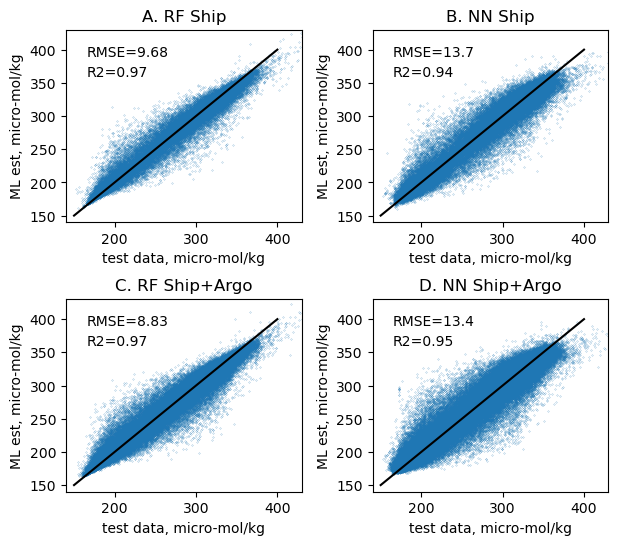

In [4]:
sublabel=['A. ','B. ','C. ','D. ']
R2=np.zeros(Nd)
RMSE=np.zeros(Nd)
fig=plt.figure(figsize=[7,6])
ax=fig.subplots(2,2)
ax=ax.flatten()
plt.subplots_adjust(hspace=.4,wspace=.3)
#
for n in range(Nd):
    test = np.load(f'/glade/campaign/univ/ugit0034/ML4O2_results/o2test_pred_v{versions[n]}.npz')
    o2est = test['est']
    o2test= test['test']
    #
    tmp=np.corrcoef(o2est,o2test)
    R2[n] = tmp[0,1]**2
    #
    RMSE[n] = np.sqrt(np.mean((o2est-o2test)**2))
    ax[n].plot(o2test,o2est,'.',markersize=.3,label='validation')
    ax[n].plot([150,400],[150,400],'k-',label='1:1 line')
    ax[n].set_xlabel('test data, micro-mol/kg')
    ax[n].set_ylabel('ML est, micro-mol/kg')
    ax[n].set_title(sublabel[n]+vernote[n])
    ax[n].text(165,390,'RMSE='+str(RMSE[n])[:4])
    ax[n].text(165,360,'R2='+str(R2[n])[:4])
    ax[n].set_xlim(140,430)
    ax[n].set_ylim(140,430)
#ax[3].legend()
#
print('R2='+str(R2))
print('RMSE='+str(RMSE))
#
R2all = R2.copy()
RMSEall=RMSE.copy()

## More in-depth comparison
- Spatial pattern of misfit between test data and ML estimates
- Start by generating a function that retrieves the spatial information

In [5]:
def rev_trans_validation(basin,nver):
    # get the data first
    params = np.load(f'/glade/campaign/univ/ugit0034/ML4O2_results/ML_params_v{versions[nver]}.npz')
    test = np.load(f'/glade/campaign/univ/ugit0034/ML4O2_results/o2test_pred_v{versions[nver]}.npz')
    R2=np.zeros(5)
    RMSE=np.zeros(5)
    #
    # read in X, Y, Z coordinates
    Xm = params['Xm']
    Xstd = params['Xstd']
    X = test['Xtest'][:,2]*Xstd[2] + Xm[2]
    Y = test['Xtest'][:,3]*Xstd[3] + Xm[3]
    Z = test['Xtest'][:,4]*Xstd[4] + Xm[4]
    YR= test['Xtest'][:,5]*Xstd[5] + Xm[5]
    MO= test['Xtest'][:,6]*Xstd[6] + Xm[6]
    sect=np.zeros(np.size(X))
    #
    # transform X, Y into long180 and lati for the Southern Ocean
    # and subdivide into sectors
    if basin==4:
        # Basin boundaries
        BB = [-130,-60,20,90,160,230]
        SOsector = ['Bellingshausen-Amundsen Sea','Weddell Sea','South Indian Ocean',
             'Southwestern Pacific Ocean','Ross Sea']
        tang = Y/X
        long180=np.zeros(np.size(X))
        long = np.arctan(tang)
        d1 = (X>0)&(Y>0)
        d2 = (X<=0)&(Y>0)
        d3 = (X<=0)&(Y<=0)
        d4 = (X>0)&(Y<=0)
        #
        long180[d1]=long[d1]
        long180[d2]=long[d2]+np.pi
        long180[d3]=long[d3]-np.pi
        long180[d4]=long[d4]
        long180 = long180/np.pi*180+20
        #
        offset=(long180>180)
        long180[offset]=long180[offset]-360
        offset=(long180<-180)
        long180[offset]=long180[offset]+360
        lati=np.sqrt(X**2 + Y**2)-90
        #
        # Give a sector (sub-basin) flags
        for n in range(5):
            if n == 4:
                selb = (long180>=BB[n])|(long180<BB[0])
            else:
                selb = (long180>=BB[n])&(long180<BB[n+1])
            o2est = test['est']
            o2test= test['test']
            #
            tmp=np.corrcoef(o2est[selb],o2test[selb])
            R2[n] = tmp[0,1]**2
            RMSE[n] = np.sqrt(np.mean((o2est[selb]-o2test[selb])**2))
            sect[selb]=n
    # if not in the Southern Ocean, return the whole basin info.
    else:
        long180 = X
        lati = Y
        o2est = test['est']
        o2test= test['test']
        sect=0
        tmp=np.corrcoef(o2est,o2test)
        R2 = tmp[0,1]**2
        RMSE = np.sqrt(np.mean((o2est[selb]-o2test[selb])**2))
    #
    return R2,RMSE,lati,long180,Z,o2est,o2test,sect,YR,MO

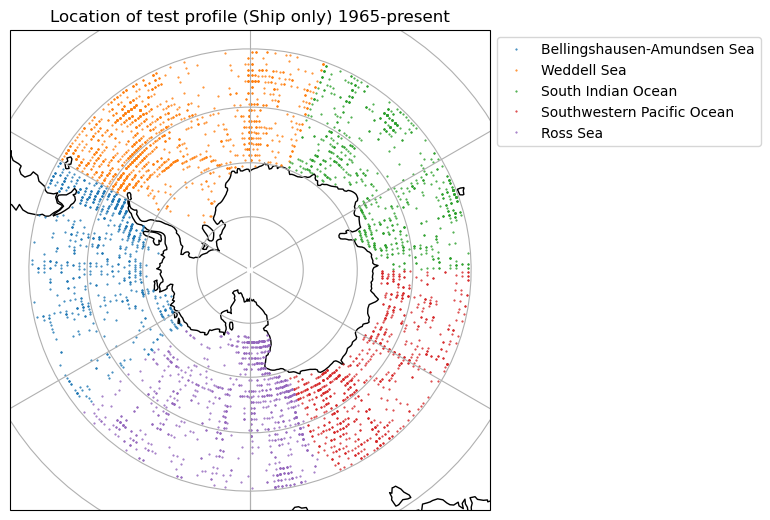

In [6]:
R2,RMSE,lat,lon,depth,o2est,o2test,sect,YR,MO = rev_trans_validation(4,0)
fig=plt.figure(figsize=[6,6])
ax=fig.add_axes([.1,.1,.8,.8],projection=ccrs.Stereographic(central_latitude=-90))
for n in range(5):
    cond=(sect==n)&(depth<20)
    ax.plot(lon[cond],lat[cond],'.',markersize=1,transform=ccrs.PlateCarree(),label=SOsector[n])
ax.coastlines()
ax.gridlines()
ax.set_title('Location of test profile (Ship only) 1965-present')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(f'test_data_location_ship.pdf',bbox_inches='tight')


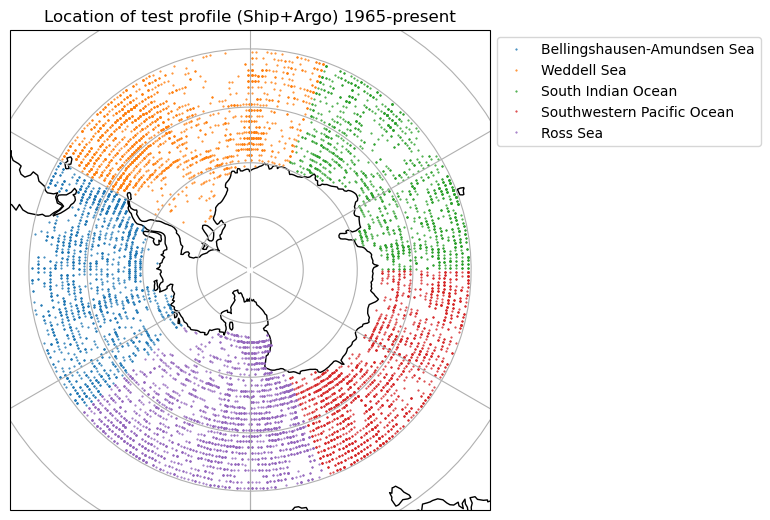

In [7]:
R2,RMSE,lat,lon,depth,o2est,o2test,sect,YR,MO = rev_trans_validation(4,2)
fig=plt.figure(figsize=[6,6])
ax=fig.add_axes([.1,.1,.8,.8],projection=ccrs.Stereographic(central_latitude=-90))
for n in range(5):
    cond=(sect==n)&(depth<20)
    ax.plot(lon[cond],lat[cond],'.',markersize=1,transform=ccrs.PlateCarree(),label=SOsector[n])
ax.coastlines()
ax.gridlines()
ax.set_title('Location of test profile (Ship+Argo) 1965-present')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(f'test_data_location_ship+Argo.pdf',bbox_inches='tight')

In [8]:
# Investigate the horizontal pattern of misfit
#
def plot_validation_xy(basin,Ztarget,maxO2):
    Zrange = [Ztarget-25,Ztarget+25]
    #maxO2  = 60
    #
    # display the misfit between ML and test data
    fig=plt.figure(figsize=[7,6])
    #ax=fig.add_axes([.1,.55,.35,.35],projection=ccrs.Stereographic(central_latitude=-90))
    ax=fig.subplots(2,2,subplot_kw={'projection': ccrs.Stereographic(central_latitude=-90)})
    ax=ax.flatten()
    sublabel=['A. ','B. ','C. ','D. ']
    #
    for n in range(4):
        R2,RMSE,lat,lon,depth,o2est,o2test,sect,YR,MO = rev_trans_validation(basin,n)
        d=o2est - o2test
        dd=np.abs(d)/np.std(d)*3
        #
        ax[n].set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        cond=(depth<Zrange[1]) & (depth>=Zrange[0])
        im=ax[n].scatter(lon[cond],lat[cond],dd[cond],d[cond],
                         cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-maxO2,vmax=maxO2)
        #ax[n].gridlines()
        for m in range(5):
            ax[n].plot([BB[m],BB[m]],[-90,-40],linewidth=1,color='k',alpha=0.5,transform=ccrs.PlateCarree())
        ax[n].coastlines()
        #
        # set up circular boundary at 30 degree south
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax[n].set_boundary(circle, transform=ax[n].transAxes)
        ax[n].set_title(sublabel[n]+vernote[n])
    #
    plt.colorbar(im,ax=ax[:],shrink=.6,location='right',
                 label=f'(ML)-(test) {Zrange[0]}-{Zrange[1]}m, micro-mol/kg')
    plt.savefig(f'validation_{Zrange[0]}-{Zrange[1]}.pdf',bbox_inches='tight')

In [9]:
Zlev = np.unique(depth)
Nz   = np.size(Zlev)
dave = np.zeros(Nz)
dstd = np.zeros(Nz)
cm=plt.get_cmap('tab20')

In [10]:
# Investigate the vertical pattern of misfit
def plot_validation_z(basin,maxO2):
    SOsec=['B-A','Weddell','S-Ind','SW-Pac','Ross']
    # display the misfit between ML and test data
    fig=plt.figure(figsize=[7,6])
    ax=fig.subplots(2,2)
    plt.subplots_adjust(hspace=.3,wspace=.3)
    ax=ax.flatten()
    sublabel=['A. ','B. ','C. ','D. ']
    #----
    for n in range(4):
        R2,RMSE,lat,lon,depth,o2est,o2test,sect,YR,MO = rev_trans_validation(basin,n)
        d=o2est - o2test
        for sector in range(5):
            for k in range(Nz):
                cond=(sect==sector)&(depth==Zlev[k])
                dave[k] = np.mean(d[cond])
                dstd[k] = np.std(d[cond])
            ax[n].plot(dave-dstd,Zlev,linewidth=0.5,color=cm(sector))
            ax[n].plot(dave+dstd,Zlev,linewidth=0.5,color=cm(sector))
            ax[n].plot(dave,Zlev,color=cm(sector),label=SOsec[sector])
            ax[n].set_ylim(1000,0)
            ax[n].set_xlim(-maxO2,maxO2)
            ax[n].set_title(sublabel[n]+vernote[n])
    ax[3].legend(bbox_to_anchor=[1,1])
    ax[2].set_xlabel('O2err $\pm \sigma$, micro-mol/kg')
    ax[3].set_xlabel('O2err $\pm \sigma$, micro-mol/kg')
    ax[0].set_ylabel('depth, m')
    ax[2].set_ylabel('depth, m')
    plt.savefig(f'validation_profile.pdf',bbox_inches='tight')

<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
/glade/derecho/scratch/ito/tmp/ipykernel_17018/988706873.py:26: SyntaxWarning: invalid escape sequence '\p'
  ax[2].set_xlabel('O2err $\pm \sigma$, micro-mol/kg')
/glade/derecho/scratch/ito/tmp/ipykernel_17018/988706873.py:27: SyntaxWarning: invalid escape sequence '\p'
  ax[3].set_xlabel('O2err $\pm \sigma$, micro-mol/kg')


/glade/u/home/ito/miniconda3/envs/ml4o2_v2/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/glade/u/home/ito/miniconda3/envs/ml4o2_v2/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/glade/u/home/ito/miniconda3/envs/ml4o2_v2/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/u/home/ito/miniconda3/envs/ml4o2_v2/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/glade/u/home/ito/miniconda3/envs/ml4o2_v2/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


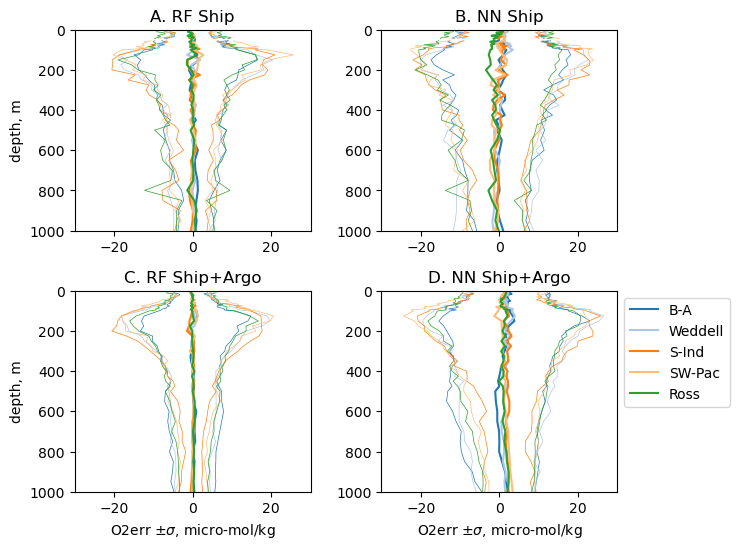

In [11]:
# generate the vertical profile of misfit
plot_validation_z(4,30)

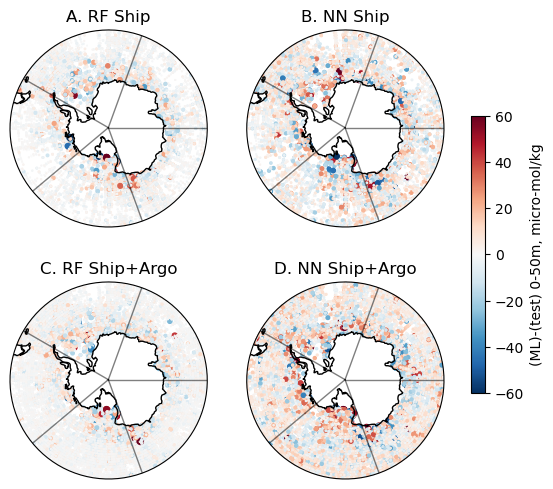

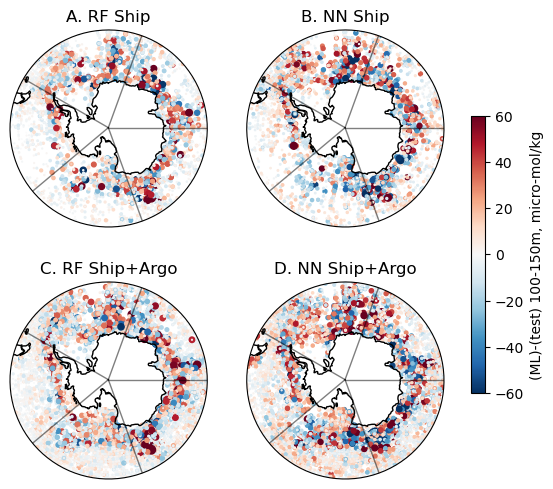

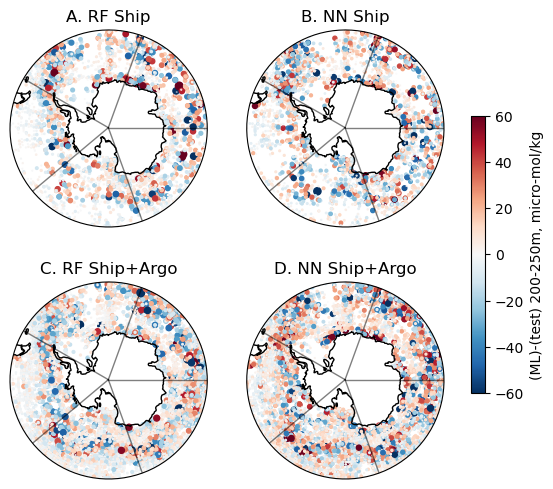

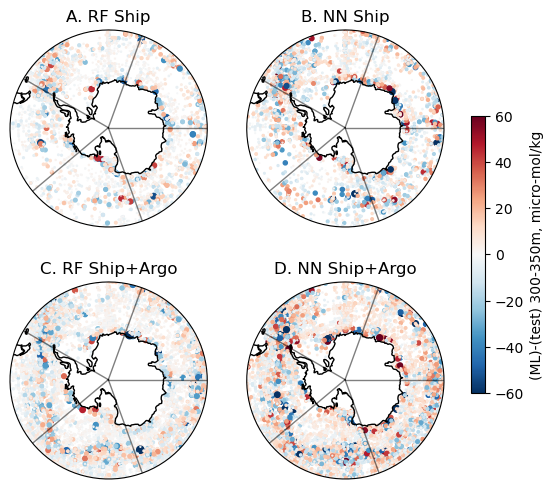

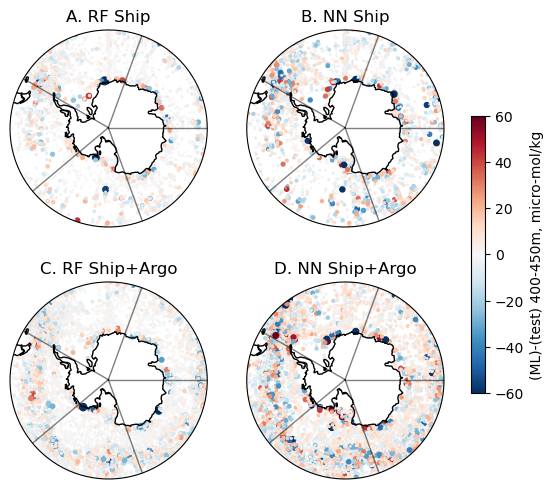

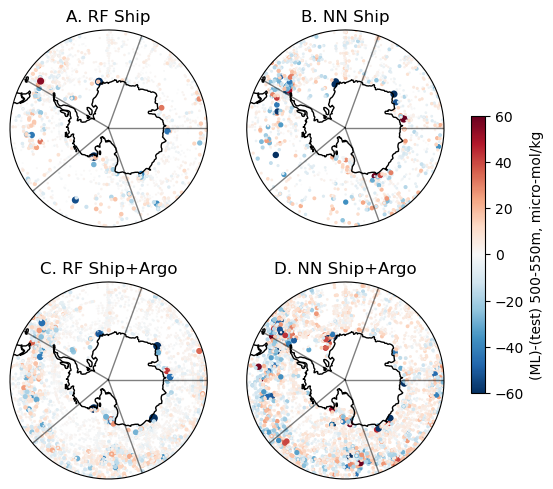

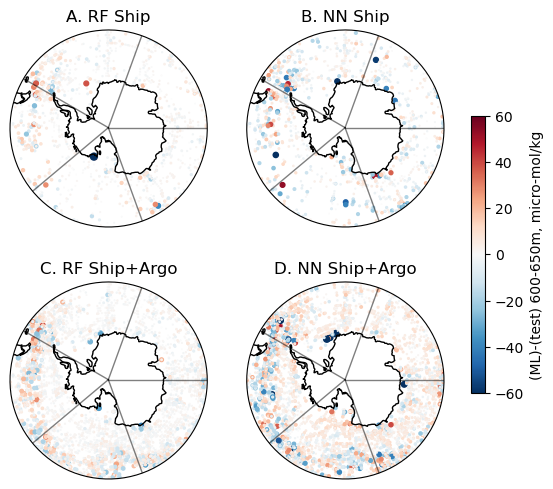

In [12]:
Zlist=[25,125,225,325,425,525,625]
for n,zlist in enumerate(Zlist):
    plot_validation_xy(4,zlist,60)

In [13]:
# get annual WOA data
dc=xr.open_mfdataset('/glade/campaign/univ/ugit0034/woa18/monthly/woa18_all_o*',decode_times=False)
o2woa = dc.o_an.sel(depth=slice(0,1000)).mean('time').to_numpy()
long=dc.lon.to_numpy()
# Give a sector (sub-basin) flags
N=o2woa.shape
o2x=np.nan*np.zeros((N[0],N[1],5))
o2xSO=np.nan*np.zeros((N[0],N[1],5))
latwoa=dc.lat.to_numpy()
depwoa=dc.depth.sel(depth=slice(0,1000)).to_numpy()
dm=xr.open_dataset('/glade/campaign/univ/ugit0034/O2_map/basin_mask_01.nc')
mask=dm.basin_mask.to_numpy()
mcode=[1,2,3,10,11]
mask0=mask[0,:,:]
for n in range(5):
    tmp0=np.where(mask0==mcode[n],1,np.nan)
    o2x[:,:,n] = np.nanmean(o2woa*tmp0,axis=2)
#
for n in range(5):
    if n == 4:
        selb = (long>=BB[n])|(long<BB[0])
    else:
        selb = (long>=BB[n])&(long<BB[n+1])
    o2xSO[:,:,n] = np.nanmean(o2woa[:,:,selb],axis=2)

/glade/derecho/scratch/ito/tmp/ipykernel_17018/1654676416.py:17: RuntimeWarning: Mean of empty slice
  o2x[:,:,n] = np.nanmean(o2woa*tmp0,axis=2)
/glade/derecho/scratch/ito/tmp/ipykernel_17018/1654676416.py:24: RuntimeWarning: Mean of empty slice
  o2xSO[:,:,n] = np.nanmean(o2woa[:,:,selb],axis=2)


In [14]:
# Investigate the vertical/latitudinal pattern of misfit
def plot_validation_yz(basin,maxO2):
    Basi=['Atantic','Pacific','Indian','SO','AO']
    # display the misfit between ML and test data
    fig=plt.figure(figsize=[7,6])
    ax=fig.subplots(2,2)
    plt.subplots_adjust(hspace=.3,wspace=.3)
    ax=ax.flatten()
    sublabel=['A. ','B. ','C. ','D. ']
    #
    for n in range(4):
        R2,RMSE,lat,lon,depth,o2est,o2test,sect,YR,MO = rev_trans_validation(basin,n)
        d=o2est - o2test
        dd=np.abs(d)/np.std(d)*3
        #cond=(sect==sector)
        im=ax[n].scatter(lat,depth,dd,d,edgecolor='face',
                         cmap='RdBu_r',vmin=-maxO2,vmax=maxO2)
        ax[n].set_title(sublabel[n]+vernote[n])
        cs=ax[n].contour(latwoa,depwoa,o2x[:,:,basin-1],np.arange(0,400,20),
                     linewidths=2,alpha=.5,cmap='Grays')
        plt.clabel(cs)
        ax[n].set_ylim(1000,0)
        #ax[n].set_xlim(-80,-50)
        #
    #
    plt.colorbar(im,ax=ax[:],shrink=.6,location='right',
                 label=f'(ML)-(test), {Basi[basin]}, micro-mol/kg')
    plt.savefig(f'validation_{Basi[basin]}.pdf',bbox_inches='tight')

In [15]:
# Investigate the vertical/latitudinal pattern of misfit
def plot_validation_yz_SO(sector,maxO2):
    #sector = 1
    #maxO2  = 60
    SOsec=['B-A','Weddell','S-Ind','SW-Pac','Ross']
    # display the misfit between ML and test data
    fig=plt.figure(figsize=[7,6])
    ax=fig.subplots(2,2)
    plt.subplots_adjust(hspace=.3,wspace=.3)
    ax=ax.flatten()
    sublabel=['A. ','B. ','C. ','D. ']
    #
    for n in range(4):
        R2,RMSE,lat,lon,depth,o2est,o2test,sect,YR,MO = rev_trans_validation(4,n)
        d=o2est - o2test
        dd=np.abs(d)/np.std(d)*3
        cond=(sect==sector)
        im=ax[n].scatter(lat[cond],depth[cond],dd[cond],d[cond],edgecolor='face',
                         cmap='RdBu_r',vmin=-maxO2,vmax=maxO2)
        ax[n].set_title(sublabel[n]+vernote[n])
        cs=ax[n].contour(latwoa,depwoa,o2xSO[:,:,sector],np.arange(0,400,20),
                     linewidths=2,alpha=.5,cmap='Grays')
        plt.clabel(cs)
        ax[n].set_ylim(1000,0)
        ax[n].set_xlim(-80,-50)
        #
    #
    plt.colorbar(im,ax=ax[:],shrink=.6,location='right',
                 label=f'(ML)-(test), {SOsec[sector]}, micro-mol/kg')
    plt.savefig(f'validation_{SOsec[sector]}.pdf',bbox_inches='tight')

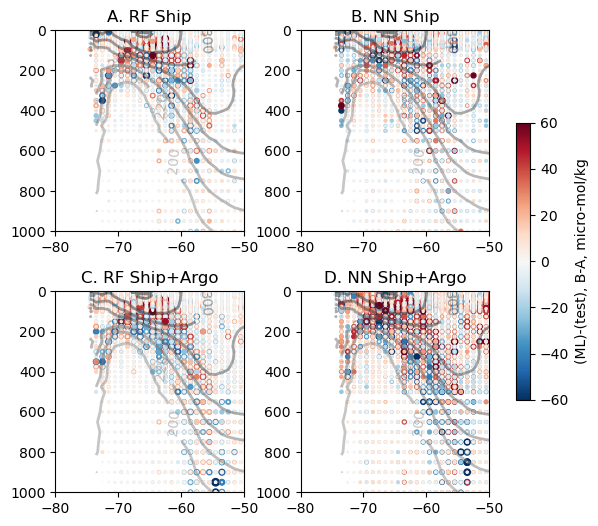

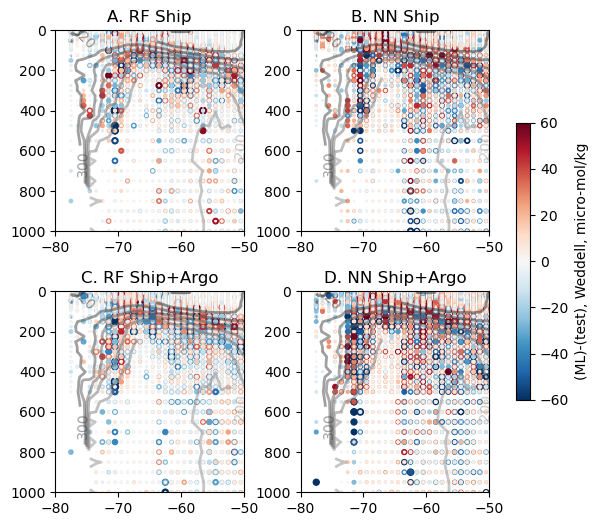

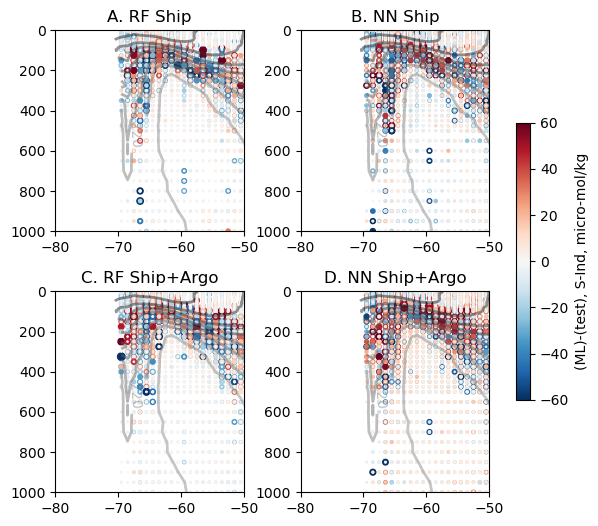

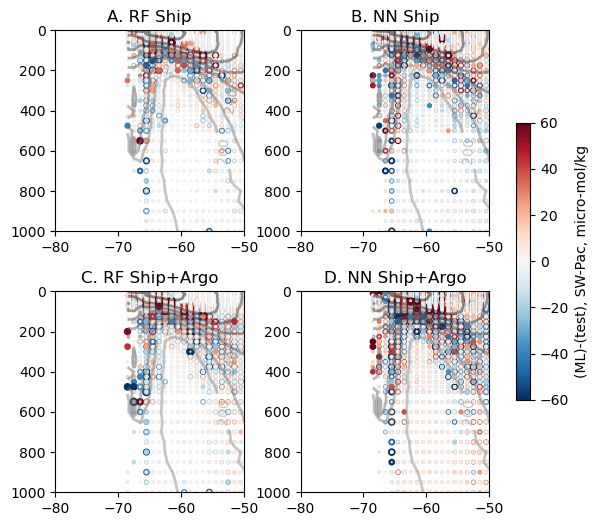

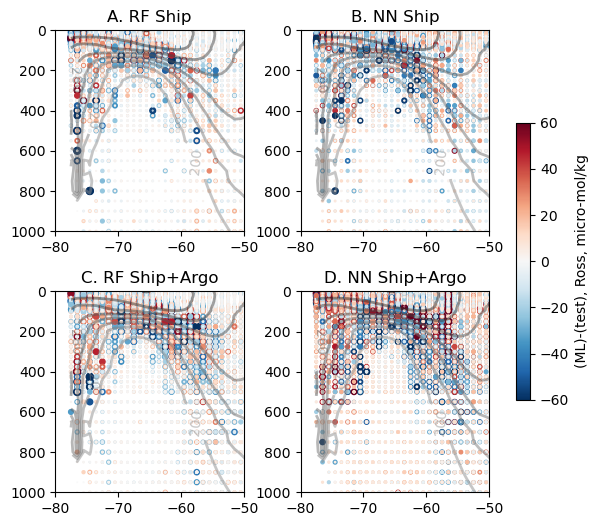

In [16]:
# loop over 5 zones of the Antarctic region
for n in range(5):
    plot_validation_yz_SO(n,60)

In [17]:
R2=np.zeros((Nd,5))
RMSE=np.zeros((Nd,5))
#
for n in range(Nd):
    R2n,RMSEn,lat,lon,depth,o2est,o2test,sect,YR,MO = rev_trans_validation(4,n)
    R2[n,:] = R2n
    RMSE[n,:] = RMSEn

/glade/derecho/scratch/ito/tmp/ipykernel_17018/2864699439.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[n].set_xticklabels(SOsec,rotation=30)
/glade/derecho/scratch/ito/tmp/ipykernel_17018/2864699439.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[n].set_xticklabels(SOsec,rotation=30)
/glade/derecho/scratch/ito/tmp/ipykernel_17018/2864699439.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[n].set_xticklabels(SOsec,rotation=30)
/glade/derecho/scratch/ito/tmp/ipykernel_17018/2864699439.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[n].set_xticklabels(SOsec,rotation=30)


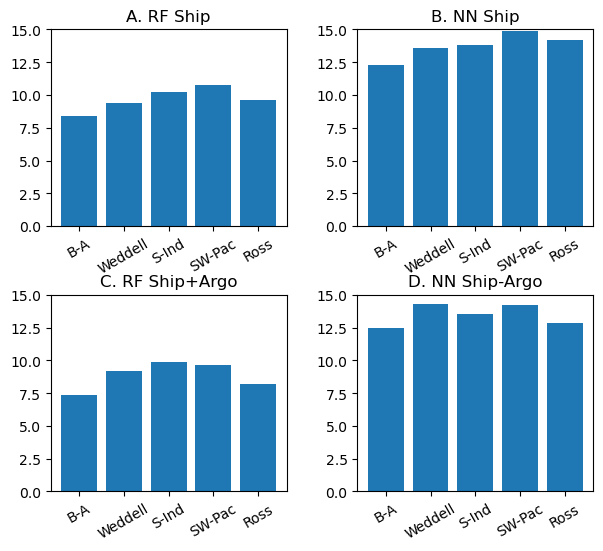

In [18]:
fig=plt.figure(figsize=(7,6))
ax=fig.subplots(2,2)
plt.subplots_adjust(hspace=.35,wspace=.3)
ax=ax.flatten()
n=0
lab=['A. RF Ship','B. NN Ship','C. RF Ship+Argo','D. NN Ship-Argo']
#
SOsec=['B-A','Weddell','S-Ind','SW-Pac','Ross']
for n in range(4):
    ax[n].bar(SOsec,RMSE[n,:])
    ax[n].set_xticklabels(SOsec,rotation=30)
    ax[n].set_ylim(0,15)
    ax[n].set_title(lab[n])